In [19]:
import pandas as pd
from sklearn.metrics import classification_report
#from sklearn.metrics import make_scorer, classification_report, make_scorer, recall, f1, accuracy_score, confusion_matrix


# loading main df and list of curated reference sentences for each label
train = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "train", index_col = 0)
c_good_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_comm_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_comm_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_comm_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_comm_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_value_curated.head()

train.text_total = [message.replace("€", " euros") for message in train.text_total]
train.head(2)

,etoiles,n_avis,date_avis,text_total,codes agrégés,c_good_value,c_bad_value,c_good_efficacy,c_bad_efficacy,c_good_comm,c_bad_comm
NaN,3,3.0,2022-07-26 10:10:19,Pour l'instant toujours en attente. Pour l'ins...,bad:inefficace,0,0,0,1,0,0
NaN,3,1.0,2022-04-11 14:14:30,intérêts trop élevés.,none,0,0,0,0,0,0


In [15]:
import pandas as pd
import numpy as np
import spacy
from transformers import pipeline,AutoTokenizer, TFCamembertForSequenceClassification
import sentencepiece

# importing spacy model
nlp = spacy.load("fr_core_news_lg")

# importing  tokenizer and Camembert classifier
tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFCamembertForSequenceClassification.from_pretrained("tblard/tf-allocine")
classifier=  pipeline("text-classification", model = model, tokenizer= tokenizer)
#tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512,'return_tensors':'pt'}

2024-02-23 10:01:11.121784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [89]:
# Functions for the similarity granularity/threshold benchmark
# removing stopwords
def stop_word_text_list(text_list):
    liste_filtrée =[]
    round_count = 1
    for review in text_list:
        if round_count % 100 == 0:
            print(f"{round_count} reviews passed of {len(text_list)} - {round(round_count/len(text_list)*100,2)}% done")            
        filtre = []
        texte = nlp(review)
        liste_texte = list(texte)
        for word in liste_texte:
            if str(word) not in stop_words:
                filtre.append(str(word))
        filt_review = (" ".join(filtre))
        liste_filtrée.append(filt_review)
        round_count = round_count + 1
    return(liste_filtrée)

# labelling decision based on similarity and similarity threshold
def allocate_lab(sim_score, y_pred, thresh):
    try:
        if max(sim_score) > thresh:
            y_pred.append(1)
        else:
            y_pred.append(0)
    except:
        y_pred.append(0)

# classification report
def similarity_report(y,y_pred,f1, recall, precision, thresh):
    report_dic =classification_report(y, y_pred, output_dict=True, zero_division=0)
    f1.append(round(report_dic['macro avg']['f1-score'],2))
    recall.append(round(report_dic['macro avg']['recall'],2))
    precision.append(round(report_dic['macro avg']['precision'],2))
    print(f"threshold: {round(thresh,2)} f1-score: {f1[-1]}")
    return(f1,recall,precision)

# saving results to csv for one shot labelling using fixed threshold
def wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode):
    temp_report = pd.DataFrame({"label":[code_of_interest],
                                    "test": [test_name],
                                    "word_mode": [word_mode],
                                    "f1": f1,
                                    "precision":precision,
                                    "recall": recall,
                                    "threshold_used": [thresh],
                                    "train_valid_test": [train_test]})
    temp_report.to_csv(f"../reports/similarity/raw/{train_test}_{test_name}_{code_of_interest}_{word_mode}.csv")

# saving results to csv for grid searches of best threshold
def wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode):
    best_f1 = max(f1)
    best_thresh = round(test_thresh[f1.index(best_f1)],2)
    best_precision = round(precision[f1.index(best_f1)],2)
    best_recall = round(recall[f1.index(best_f1)],2)
    """report_best = pd.DataFrame({"thresh": [best_thresh],
                        "f1": [best_score],
                        "precision": [round(precision[f1.index(best_score)],2)],
                        "recall": [round(recall[f1.index(best_score)],2)]
                        })
    print(f"for {code_of_interest} best score: {best_score} using similarity thresh of {best_thresh}")"""
    wrap_csv(test_name,code_of_interest,best_thresh,best_f1,best_recall,best_precision, train_test, word_mode)
    
# function to compile method grid results for one label
def compile_segundo(code_of_interest, train_test):
    # compiling grid results
    from os import listdir

    bench_list = listdir("../reports/similarity/raw/")
    bench_list.remove(".DS_Store")
    bench_list = [path for path in bench_list if code_of_interest in path]
    bench_list = [path for path in bench_list if train_test in path]
    bench_list
    benchmark = pd.DataFrame()
    for file in bench_list:
        test = pd.read_csv(f'../reports/similarity/raw/{file}', index_col=0)
        benchmark = pd.concat([benchmark, test])
    print(benchmark)
    benchmark = benchmark.sort_values("f1", ascending = False)
    benchmark

# functions to check best granularity and similarity thresho
#### CORE FUNCTIONS : different text granularity combinations (sentence, whole document) for review, reference and testing keywords ####
def core_full_review_vs_whole_ref_bag(bag_of_ref,reviews, thresh):
    y_pred = []
    for message in reviews:
        sim_score = []
        message = nlp(message)
        sim_score.append(round(bag_of_ref.similarity(message),2))
        allocate_lab(sim_score, y_pred, thresh)
    return y_pred

def core_review_sentence_vs_whole_ref_bag(bag_of_ref,reviews, thresh):
    y_pred = []
    for message in reviews:
        sim_score = []
        message = nlp(message)
        sentences = message.sents
        for sentence in sentences:
            if sentence.has_vector:
                try:
                    temp_sim_score = round(bag_of_ref.similarity(sentence),2)

                    sim_score.append(temp_sim_score)
                except:
                    print("issue with vector")
                    sim_score.append(0)
        allocate_lab(sim_score, y_pred, thresh)
    return y_pred

def core_review_sentence_vs_reference_sentence(bag_of_ref,reviews, thresh):
    y_pred,trigger_ref_sent = [],[]
    for message in reviews:
        sim_score= []
        message = nlp(message)
        review_sentences = message.sents
        sentences_exemples = bag_of_ref.sents
        for review_sentence in review_sentences:
            if review_sentence.has_vector:
                for sentence_exemple in sentences_exemples:
                    if sentence_exemple.has_vector:
                        try:
                            temp_sim_score = round(review_sentence.similarity(sentence_exemple),2)
                            sim_score.append(temp_sim_score)
                        except:
                            print("issue with vector")
                            sim_score.append(0.0)
        print('sim score', sim_score)
        best_sim_score =  max(sim_score)
        list_trigger_ref_sents = [sent for sent in sentences_exemples]
        trigger_ref_sent.append(list_trigger_ref_sents[sim_score.index(best_sim_score)])
        allocate_lab(sim_score, y_pred, thresh)
    return y_pred, trigger_ref_sent

### toujours le meme f1 score??? Vaut pour les deux étalons est ce que sim score est toujours sous le seuil?
def core_review_sentence_vs_ref_étalon(etalon,reviews, thresh):
    y_pred = []
    etalon = nlp(etalon)
    for message in reviews:
        sim_score= []
        message = nlp(message)
        sentences = message.sents
        for sentence in sentences:
            if sentence.has_vector:
                try:
                    temp_sim_score = round(etalon.similarity(sentence),2)
                    sim_score.append(temp_sim_score)
                    #print("sim score review sentence:", temp_sim_score)
                except:
                    print("issue with vector")
                    sim_score.append(0)
        allocate_lab(sim_score, y_pred, thresh)
    return y_pred
        
def core_full_review_vs_étalon(etalon,reviews, thresh):
    y_pred = []
    etalon = nlp(etalon)
    for message in reviews:
        sim_score = []
        message = nlp(message)
        sim_score.append(round(etalon.similarity(message),2))
        print("sim score review sentence:", sim_score[-1])
        allocate_lab(sim_score, y_pred, thresh)
    return y_pred

#### ONE SHOT : to label using a specific similarity threshold ####

def one_shot_review_vs_whole_ref_bag(bag_of_ref,reviews, y,code_of_interest,thresh, train_test, word_mode):
    test_name = "review_vs_whole_ref_bag"
    print("passing",test_name)
    f1, recall, precision = [],[],[]
    y_pred = core_full_review_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
    f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode)

def one_shot_review_sentence_vs_whole_ref_bag(bag_of_ref,reviews, y,code_of_interest,thresh, train_test, word_mode):
    test_name = "review_sentence_vs_whole_ref_bag"
    print("passing",test_name)
    f1, recall, precision = [],[],[]
    y_pred = core_review_sentence_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
    f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode)

def one_shot_review_sentence_vs_reference_sentence(bag_of_ref,reviews, y,code_of_interest,thresh, train_test, word_mode):
    test_name = "review_sentence_vs_reference_sentence"
    print("passing",test_name)
    f1, recall, precision = [],[],[]
    y_pred = core_review_sentence_vs_reference_sentence(bag_of_ref,reviews, thresh)
    f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode)


### toujours le meme f1 score???
def one_shot_review_sentence_vs_ref_étalon(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode):
    test_name = "review_sentence_vs_ref_étalon"
    print("passing",test_name)
    f1, recall, precision = [],[],[]
    y_pred = core_review_sentence_vs_ref_étalon(etalon, reviews, train_test)
    f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode)

def one_shot_full_review_vs_étalon(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode):
    test_name = "full_review_vs_étalon"
    print("passing",test_name)
    f1, recall, precision = [],[],[]
    y_pred = core_full_review_vs_étalon(etalon,reviews, thresh)
    f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_csv(test_name,code_of_interest,thresh,f1,recall,precision, train_test, word_mode)

#### GRID ONE SHOT: fixed threshold ####
def one_shot_thresh(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode):
    one_shot_review_vs_whole_ref_bag(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode)
    one_shot_review_sentence_vs_whole_ref_bag(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode)
    one_shot_review_sentence_vs_reference_sentence(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode)
    one_shot_review_sentence_vs_ref_étalon(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode)
    one_shot_full_review_vs_étalon(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode)

#### GRID SEARCH of best threshold : seeking best accuracy with thresholds between range 0.59:1.00 ####
def grid_thresh(bag_of_ref,reviews, y,code_of_interest,thresh, etalon, train_test, word_mode):
    test_name = "core_full_review_vs_whole_ref_bag"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_full_review_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode)

    test_name = "core_review_sentence_vs_whole_ref_bag"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_review_sentence_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode)

    test_name = "core_review_sentence_vs_reference_sentence"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_review_sentence_vs_reference_sentence(bag_of_ref,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode)

    test_name = "core_review_sentence_vs_ref_étalon"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_review_sentence_vs_ref_étalon(etalon,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
        f1.append(report.f1.iloc[0])
    wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode)

    test_name = "core_full_review_vs_étalon"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_full_review_vs_étalon(etalon,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    wrap_best_thresh_and_csv(test_name,code_of_interest,train_test,f1,recall,precision, thresh, word_mode)


def baseline_grid (bag_of_ref,reviews, y,thresh):
    test_name = "review_sentence_vs_whole_ref_bag"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        y_pred = core_full_review_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    return f1

def baseline_grid_sent(bag_of_ref, code_of_interest, reviews, y, thresh):
    test_name = "review_sentence_vs_whole_ref_bag"
    print("passing ",test_name)
    f1, recall, precision = [],[],[]
    for thresh in test_thresh:
        print("passing threshold:", thresh)
        y_pred = core_full_review_vs_whole_ref_bag(bag_of_ref,reviews, thresh)
        y_pred,trigger_ref_sent = [],[]
        for message in reviews:
            sim_score= []
            message = nlp(message)
            review_sentences = message.sents
            sentences_exemples = bag_of_ref.sents
            for review_sentence in review_sentences:
                if review_sentence.has_vector:
                    resonance = check_sent(review_sentence, code_of_interest)
                    if resonance:
                        for sentence_exemple in sentences_exemples:

                            if sentence_exemple.has_vector:
                                try:
                                    temp_sim_score = round(review_sentence.similarity(sentence_exemple),2)
                                    sim_score.append(temp_sim_score)
                                except:
                                    print("issue with vector")
                                    sim_score.append(0.0)            
                    else:
            allocate_lab(sim_score, y_pred, thresh)
        f1,recall,precision = similarity_report(y,y_pred,f1,recall,precision, thresh)
    return f1


def check_sent(review_sentence, code_of_interest):
    sentiment = pd.DataFrame()
    sent_label = []
    review_sentence = review_sentence[:512] # max tokens for Camembert
    try:
        temp = classifier(review_sentence.text)[0]['label']
        sent_label.append(temp)
    except Exception as e:
        print(f"Erreur lors du traitement du texte {review_sentence}. Erreur: {e}")
    resonance = temp == "NEGATIVE" and "bad" in code_of_interest or temp == "POSITIVE" and "good" in code_of_interest
    return resonance

def compile_best_params(label,best_params):
    best_params = pd.DataFrame()
    label_names = set(benchmark["label"])
    for label in label_names:
    #print(label, label_names)
    code_df = benchmark[benchmark['label'] == label]
    best_threshold_index = code_df['f1'].idxmax()
    best_threshold = code_df['threshold_used'].iloc[best_threshold_index]
    best_method = code_df['test'].iloc[best_threshold_index]
    best_accuracy = code_df['f1'].iloc[best_threshold_index]
    best_mode = code_df['word_mode'].iloc[best_threshold_index]
    temp_df = pd.DataFrame({
    "label": [label],
    "Accuracy": [best_accuracy],
    "best_threshold": [best_threshold],
    "Method": [best_method],
    "Word mode": [best_mode]
    })
    best_params = pd.concat([best_params, temp_df], ignore_index= True)
    return best_params

IndentationError: expected an indented block (3548853461.py, line 306)

In [20]:
# all reviews text
list_exemples_tout = train.text_total

#bags with regeference text for each label
bag_good_value = nlp(" ".join([message for message in c_good_value_curated.text_total]))
bag_bad_value = nlp(" ".join([message for message in c_bad_value_curated.text_total]))
bag_good_comm = nlp(" ".join([message for message in c_good_comm_curated.text_total]))
bag_bad_comm = nlp(" ".join([message for message in c_bad_comm_curated.text_total]))
bag_good_efficacy = nlp(" ".join([message for message in c_good_efficacy_curated.text_total]))
bag_bad_efficacy = nlp(" ".join([message for message in c_bad_efficacy_curated.text_total]))

# removing stopwords: train reviews
train['text_total'] = train['text_total'].fillna('').astype(str)
train['text_total'] = [message.lower() for message in train['text_total']]
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

train["text_stop"] = stop_word_text_list(train['text_total'])

# making stop word versions of our reference documents
bag_good_comm_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_comm_curated.text_total)]))
bag_bad_comm_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_comm_curated.text_total)]))
bag_good_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_value_curated.text_total)]))
bag_bad_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_value_curated.text_total)]))
bag_good_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_efficacy_curated.text_total)]))
bag_bad_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_efficacy_curated.text_total)]))

import numpy as np
test_thresh = np.arange(0.59,1.01, 0.01)


100 reviews passed of 152 - 65.79% done


In [ ]:
# créer une version du texte listé par phrases de plus de un mot et sans ponctuation
train['text_sent_noPunct'] = ""
def create_review_sent_noPunct(df)
for i, review in enumerate(df.text_total):
    # Reconstruct sentences without punctuation
    review = nlp(review)
    sentences_without_punctuation = []
    for sent in review.sents:
        # Filter out tokens that are punctuation
        tokens_without_punctuation = [token.text for token in sent if not token.is_punct]
        if len(tokens_without_punctuation) >1:   
            # Join the tokens to form a new sentence
            new_sentence = " ".join(tokens_without_punctuation)
            sentences_without_punctuation.append(new_sentence)
    df['text_sent_noPunct'].iloc[i] = sentences_without_punctuation

# créer deux colones: une pour les phrases positives, l'autre pour les négatives
import pandas as pd
import numpy as np
import spacy
from transformers import pipeline,AutoTokenizer, TFCamembertForSequenceClassification
import sentencepiece

# importing spacy model
nlp = spacy.load("fr_core_news_lg")

# importing  tokenizer and Camembert classifier
tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFCamembertForSequenceClassification.from_pretrained("tblard/tf-allocine")
classifier=  pipeline("text-classification", model = model, tokenizer= tokenizer)
#tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512,'return_tensors':'pt'}



def creating_cols_pos_neg_sents(df):
    df['text_clean_neg'] = ""
    df['text_clean_pos'] = ""
    for i, sentence_list in enumerate(df['text_sent_noPunct']):
        pos_sent, neg_sent = [],[]
        print("new message")
        for sentence in sentence_list:
            sentence = sentence[:512] # nombre de mots max pour Camembert
            try:
                temp = classifier(sentence)[0]['label']
            except Exception as e:
                print(f"Erreur lors du traitement du texte {sentence}. Erreur: {e}")
            if temp == "POSITIVE":
                pos_sent.append(sentence)
            elif temp == "NEGATIVE":
                neg_sent.append(sentence)
        df['text_clean_neg'].iloc[i] = neg_sent
        df['text_clean_pos'].iloc[i] = pos_sent
    
    df["text_clean_pos_whole"] = ""
    for i,sentence_list in enumerate(df.text_clean_pos):
        df["text_clean_pos_whole"].iloc[i] = " ".join([sent for sent in sentence_list])

    df["text_clean_neg_whole"] = ""
    for i,sentence_list in enumerate(df.text_clean_neg):
        df["text_clean_neg_whole"].iloc[i] = " ".join([sent for sent in sentence_list])


creating_cols_pos_neg_sents()

In [ ]:
# testing using all words vs without stop words with one method: full review vs full ref for good efficacy label

baseline_all_words_sents = baseline_grid_sent(bag_good_comm,"c_good_comm", train.text_total, train.c_good_comm, test_thresh)
baseline_all_words =  baseline_grid(bag_good_comm,train.text_total, train.c_good_comm,test_thresh)
baseline_stop_words =  baseline_grid(bag_good_comm_stop,train.text_stop, train.c_good_comm,test_thresh)
baseline_stop_words_sents = baseline_grid_sent(bag_good_comm_stop,"c_good_comm", train.text_stop, train.c_good_comm, test_thresh)
import matplotlib.pyplot as plt

plt.plot(test_thresh,baseline_stop_words, label ="stop words")
plt.plot(test_thresh, baseline_all_words, label = "all words")
plt.plot(test_thresh, baseline_all_words_sents, label ="all words + sentiment")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("similarity threshold used")
plt.ylabel("f1 score")
plt.legend()
plt.show();

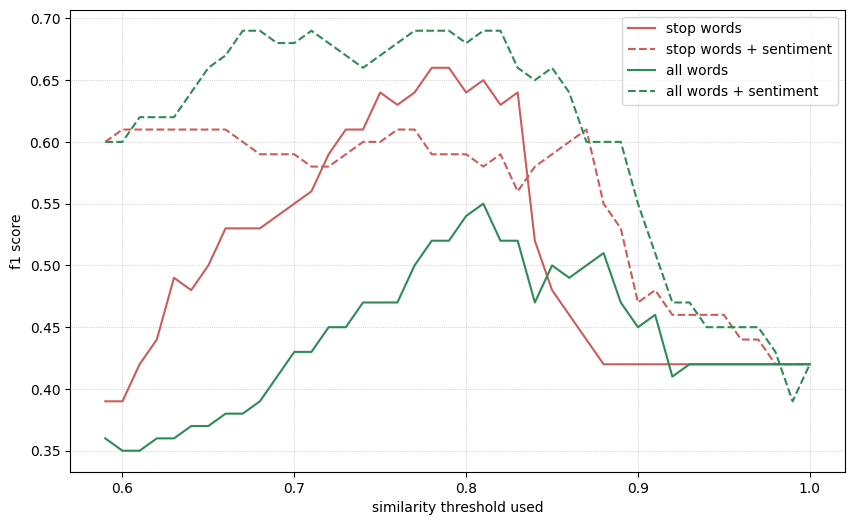

In [87]:
plt.figure(figsize=(10,6))
plt.plot(test_thresh,baseline_stop_words, label ="stop words", color ="indianred")
plt.plot(test_thresh,baseline_stop_words_sents, label ="stop words + sentiment", color ="indianred",linestyle="--")
plt.plot(test_thresh, baseline_all_words, label = "all words", color="seagreen")
plt.plot(test_thresh, baseline_all_words_sents, label ="all words + sentiment", linestyle="--", color="seagreen")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.xlabel("similarity threshold used")
plt.ylabel("f1 score")
plt.legend()
plt.show();

Adding a sentiment filter to our process can significantly increases our text sentiment similarity accuracy.
This can be explained by the fact that sentences may be very close semantically but belong to opposite labels. For instance in the case of Bad efficacy and Good efficacy: "communication with the bank was terrible", "communication with the bank was great" share a lot of semantic similarity except for the sentiment "great"/"terrible".

We will test both stop words and full words in similarity matching

Running similarity grids to test best granularity (sentence vs whole text; ref as whole ref, as sentence or replaced by keywords) for STOP words

In [210]:

# good com allwords and stopwords
grid_thresh(bag_good_comm,df.text_total, df["c_good_comm"],"c_good_comm",test_thresh, "attentif disponible poli", "train", "allwords")
grid_thresh(bag_good_comm,df.text_stop, df["c_good_comm"],"c_good_comm",test_thresh, "attentif disponible poli", "train", "stopwords")

# bad com allwords and stopwords
grid_thresh(bag_bad_comm,df.text_total, df["c_bad_comm"],"c_bad_comm",test_thresh, "malpoli mépris", "train", "allwords")
grid_thresh(bag_bad_comm,df.text_stop, df["c_bad_comm"],"c_bad_comm",test_thresh, "malpoli mépris", "train", "stopwords")

# good value allwords and stopwords
grid_thresh(bag_good_value,df.text_total, df["c_good_value"],"c_good_value",test_thresh, "abordable accordé", "train", "allwords")
grid_thresh(bag_good_value_stop,df.text_stop, df["c_good_value"],"c_good_value",test_thresh, "abordable accordé", "train", "stopwords")

# bad value allwords and stopwords
grid_thresh(bag_bad_value,df.text_total, df["c_bad_value"],"c_bad_value",test_thresh, "cher refusé", "train", "allwords")
grid_thresh(bag_bad_value,df.text_stop, df["c_bad_value"],"c_bad_value",test_thresh, "cher refusé", "train","stopwords")

# good efficacy allwords and stopwords
grid_thresh(bag_good_efficacy,df.text_total, df["c_good_efficacy"],"c_good_efficacy",test_thresh, "super efficace rapide", "train", "allwords")
grid_thresh(bag_good_efficacy,df.text_stop, df["c_good_efficacy"],"c_good_efficacy",test_thresh, "super efficace rapide", "train", "stopwords")

# bad efficacy allwords and stopwords
grid_thresh(bag_bad_efficacy,df.text_total, df["c_bad_efficacy"],"c_bad_efficacy",test_thresh, "malpoli mépris", "train", "allwords")
grid_thresh(bag_bad_efficacy,df.text_stop, df["c_bad_efficacy"],"c_bad_efficacy",test_thresh, "malpoli mépris", "train", "stopwords")


passing  core_full_review_vs_whole_ref_bag
threshold: 0.59 f1-score: 0.36
threshold: 0.6 f1-score: 0.35
threshold: 0.61 f1-score: 0.35
threshold: 0.62 f1-score: 0.36
threshold: 0.63 f1-score: 0.36
threshold: 0.64 f1-score: 0.37
threshold: 0.65 f1-score: 0.37
threshold: 0.66 f1-score: 0.38
threshold: 0.67 f1-score: 0.38
threshold: 0.68 f1-score: 0.39
threshold: 0.69 f1-score: 0.41
threshold: 0.7 f1-score: 0.43
threshold: 0.71 f1-score: 0.43
threshold: 0.72 f1-score: 0.45
threshold: 0.73 f1-score: 0.45
threshold: 0.74 f1-score: 0.47
threshold: 0.75 f1-score: 0.47
threshold: 0.76 f1-score: 0.47
threshold: 0.77 f1-score: 0.5
threshold: 0.78 f1-score: 0.52
threshold: 0.79 f1-score: 0.52
threshold: 0.8 f1-score: 0.54
threshold: 0.81 f1-score: 0.55
threshold: 0.82 f1-score: 0.52
threshold: 0.83 f1-score: 0.52
threshold: 0.84 f1-score: 0.47
threshold: 0.85 f1-score: 0.5
threshold: 0.86 f1-score: 0.49
threshold: 0.87 f1-score: 0.5
threshold: 0.88 f1-score: 0.51
threshold: 0.89 f1-score: 0.47
th

KeyboardInterrupt: 

Let's make a heatmap to see the F1 Scores of the different methods

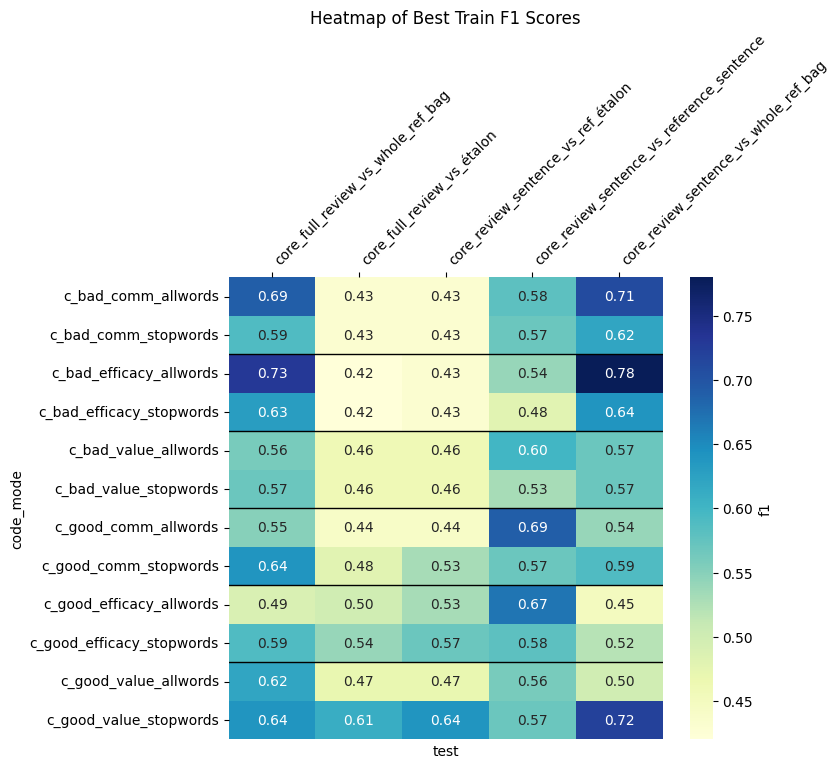

In [177]:
from os import listdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compile the grid results

def compile_benchmarks (test_train):
    bench_list = listdir("../reports/similarity/raw")
    try: 
        bench_list.remove(".DS_Store")
    except:
        print("error in remove")
        
    bench_list = [path for path in bench_list if "baseline" not in path]
    bench_list = [path for path in bench_list if test_train in path]
    
    benchmark = pd.DataFrame()
    for file in bench_list:
        df = pd.read_csv(f'../reports/similarity/raw/{file}', index_col=0)
        benchmark = pd.concat([benchmark, df])
    benchmark = benchmark.sort_values("f1", ascending = False)
    benchmark['code_mode'] = benchmark.label + "_" + benchmark['word_mode']
    return benchmark

benchmark = compile_benchmarks("train")

def heat():
    # pivot table heatmap
    pivot = benchmark.pivot_table(index='code_mode', columns='test', values='f1')
    plt.figure(figsize=(7, 6))  
    heatmap = sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0, linecolor='grey')

    # horizontal lines 
    for i in range(2, len(pivot.index), 2):
        plt.axhline(i, color='black', linestyle='-', linewidth=1)

    # Label the color bar
    color_bar = heatmap.collections[0].colorbar
    color_bar.set_label('f1')

    plt.title('Heatmap of Best Train F1 Scores')
    heatmap.xaxis.tick_top() 
    plt.xticks(rotation=45, ha='left')  # Align the x-ticks properly
    plt.show()
heat()

The heatmap shows that using **keywords** (étalon) generraly drives _worse results_ than example based solutions, all the more so for labels that have many exemples (bad communicatin, bad efficacy). 

Results are more _nuanced_ regarding the use of **all words** or **removing stopwords** and on using the **whole document** (review or reference exemples) or **sentence** based similarity scoring. 

**The better F1 Scores** were obtained using:
* Full review vs full reference document using:
    * stopwords (for c_good_value_allwords **.65**, c_bad_efficacy_stop **.74**)
    * allwords (c_bad_com_stop, **70**, c_bad_efficacy_allwords **.74**, c_good_efficacy_allwords **.67**)
* Review sentence vs reference sentences with all words (c_good_comm_allwords **.69**),
* Review sentence vs whole reference document using both:
    * All words (c_bad_efficacy_allwords **.78**, c_bad_com_allwords **.71**).
    * Stop (c_bad_efficacy_stop **.71**, c_good_value_stop **.67**) 

One label labels has F1-scores under .65: c_bad_value_stop (**.62**) using review sentences vs whole reference document

Overall **results could be improved** by:
* **Labelling more messages** to make more robust training dataset. 
    * If the selection of the labels reference sentences  becomes tedious with larger sets, it could be automated by running **TF/IDF** between the reference documents and only keeping words which are prevalent and relevant to each. For this smaller subset I prefered to rely on my own judgment and experience in qualitative research to select best sentences.
* Using a **stronger deep learning models like Camembert** (or BERT for English):
    * for finer semantic text similarity. Here we used fr_core_news_lg which has less parameters but can be conveniently used within spaCy.
    * to add a decision layer based on sentiment of the sentence to distinguish between negative and positive user sentiment within a thematic context, for instance "très mauvaise relation client avec le conseiller" and "très bonne relation client avec le conseiller" have very similar semantics and can trigger false positives when trying to label for either c_good_com or c_bad_com.

These results are based on the training dataset, we will run the best parameters on the **test** dataset to see how our scores handle unseen data.

To do that, we will extract the **optimal parameters** (document granularity, all word/stopwords, optimal threshold) to run the labelling on the test and then on the larger dataset in the best available conditions.

In [91]:
benchmark[0:1]

,label,test,word_mode,f1_score,threshold_used,code_mode
0,c_bad_efficacy,train_review_sentence_vs_whole_ref_bag,allwords,0.78,0.84,c_bad_efficacy_allwords


In [196]:
best_params = pd.DataFrame()
def compile_best_params(label,best_params):
    code_df = benchmark[benchmark['label'] == label]
    best_threshold_index = code_df['f1'].idxmax()
    best_threshold = code_df['threshold_used'].iloc[best_threshold_index]
    best_method = code_df['test'].iloc[best_threshold_index]
    best_accuracy = code_df['f1'].iloc[best_threshold_index]
    best_mode = code_df['word_mode'].iloc[best_threshold_index]

    temp_df = pd.DataFrame({
        "label": [label],
        "Accuracy": [best_accuracy],
        "best_threshold": [best_threshold],
        "Method": [best_method],
        "Word mode": [best_mode]
    })
    best_params = pd.concat([best_params, temp_df], ignore_index= True)
    return best_params
label_names = set(benchmark["label"])
for label in label_names:
    best_params = compile_best_params(label,best_params)
best_params


,label,Accuracy,best_threshold,Method,Word mode
0,c_good_efficacy,0.45,0.82,review_sentence_vs_reference_sentence,allwords
1,c_bad_value,0.44,0.80,review_sentence_vs_reference_sentence,allwords
2,c_bad_efficacy,0.71,0.84,review_sentence_vs_whole_ref_bag,allwords
3,c_good_value,0.48,0.80,review_sentence_vs_whole_ref_bag,stopwords
4,c_good_comm,0.61,0.82,review_sentence_vs_reference_sentence,allwords
5,c_bad_comm,0.61,0.83,review_sentence_vs_whole_ref_bag,allwords


In [166]:
# save best parameters
best_params.to_csv('../reports/similarity/best_params.csv')

# check selected methods
set(best_params.Method)

{'core_review_sentence_vs_reference_sentence',
 'core_review_sentence_vs_whole_ref_bag'}

# Validation

In [264]:
df.text_total.iloc[1]

'intérêts trop élevés.'

In [259]:
test = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "test", index_col= 0)
test.text_total = [message.replace("€", " euros") for message in test.text_total]
test["text_stop"] = stop_word_text_list(test['text_total'])

In [268]:
one_shot_review_sentence_vs_reference_sentence(bag_good_efficacy,test.text_total, test.c_good_efficacy,"c_good_efficacy",0.82,  "validation", "allwords")

passing review_sentence_vs_reference_sentence
ooo for review sentence: organisme à éviter absolument.
xxx and ref sentence Je suis satisfaite du suivi  merci  à l'equipe  monabanq aide précieuse, explications et renseignements complets et accessibles.
temp sim score: 0.67
sim score list: []
      
ooo for review sentence: organisme à éviter absolument.
xxx and ref sentence Tout et rapide du moment  que le dossier  et fait l argent  arrive  rapidement  merci simplicité rapidité et des personnes compétentes au bout du fil chose plutôt rare de nos jours.
temp sim score: 0.63
sim score list: [0.67]
      
ooo for review sentence: organisme à éviter absolument.
xxx and ref sentence Pour la demande de crédit en ligne avec une pré-acceptation rapide.
temp sim score: 0.64
sim score list: [0.67, 0.63]
      
ooo for review sentence: organisme à éviter absolument.
xxx and ref sentence Celà ma permis de m'engager sur une négociation avec une certaine assurance financière.
temp sim score: 0.54
sim

IndexError: list index out of range

In [198]:
# running the labelling on validation sets using the best parameters from the training 

# good efficacy
one_shot_review_sentence_vs_reference_sentence(bag_good_efficacy,test.text_total, test.c_good_efficacy,"c_good_efficacy",0.82,  "validation", "allwords")
# bad value
one_shot_review_sentence_vs_reference_sentence(bag_bad_value,test.text_total, test.c_bad_value,"c_bad_value",0.80,  "validation", "allwords")
# bad efficacy 
one_shot_review_sentence_vs_whole_ref_bag(bag_bad_efficacy,test.text_total, test.c_bad_efficacy,"c_bad_efficacy",0.84,  "validation", "allwords")
# good value
one_shot_review_sentence_vs_whole_ref_bag(bag_good_value,test.text_stop, test.c_good_value,"c_good_value",0.80, "validation", "stopwords")
# good comm
one_shot_review_sentence_vs_reference_sentence(bag_good_comm,test.text_total, test.c_good_comm,"c_good_comm",0.82,  "validation", "allwords")
# bad comm 
one_shot_review_sentence_vs_whole_ref_bag(bag_bad_comm,test.text_total, test.c_bad_comm,"c_bad_comm",0.83,  "validation", "allwords")


passing review_sentence_vs_reference_sentence
threshold: 0.82 f1-score: 0.45
passing review_sentence_vs_reference_sentence
threshold: 0.8 f1-score: 0.44
passing review_sentence_vs_whole_ref_bag
threshold: 0.84 f1-score: 0.71
passing review_sentence_vs_whole_ref_bag
threshold: 0.8 f1-score: 0.48
passing review_sentence_vs_reference_sentence
threshold: 0.82 f1-score: 0.61
passing review_sentence_vs_whole_ref_bag
threshold: 0.83 f1-score: 0.61


In [199]:
benchmark = compile_benchmarks("validation")
benchmark

,label,test,word_mode,f1,precision,recall,threshold_used,train_valid_test,code_mode
0,c_bad_efficacy,review_sentence_vs_whole_ref_bag,allwords,0.71,0.72,0.71,0.84,validation,c_bad_efficacy_allwords
0,c_bad_comm,review_sentence_vs_whole_ref_bag,allwords,0.61,0.61,0.63,0.83,validation,c_bad_comm_allwords
0,c_good_comm,review_sentence_vs_reference_sentence,allwords,0.61,0.60,0.68,0.82,validation,c_good_comm_allwords
0,c_good_value,review_sentence_vs_whole_ref_bag,stopwords,0.48,0.45,0.50,0.80,validation,c_good_value_stopwords
0,c_good_efficacy,review_sentence_vs_reference_sentence,allwords,0.45,0.46,0.45,0.82,validation,c_good_efficacy_allwords
0,c_bad_value,review_sentence_vs_reference_sentence,allwords,0.44,0.44,0.44,0.80,validation,c_bad_value_allwords


The results are not optimal, we will run a grid search to find better thresholds for the validation set

In [212]:
# good com allwords and stopwords
grid_thresh(bag_good_comm,test.text_total, test["c_good_comm"],"c_good_comm",test_thresh, "attentif disponible poli", "validation", "allwords")
grid_thresh(bag_good_comm_stop,test.text_total, test["c_good_comm"],"c_good_comm",test_thresh, "attentif disponible poli", "validation", "stopwords")

# bad com allwords and stopwords
grid_thresh(bag_bad_comm,test.text_total, test["c_bad_comm"],"c_bad_comm",test_thresh, "malpoli mépris", "validation", "allwords")
grid_thresh(bag_bad_comm_stop,test.text_total, test["c_bad_comm"],"c_bad_comm",test_thresh, "malpoli mépris", "validation", "stopwords")

# good value allwords and stopwords
grid_thresh(bag_good_value,test.text_total, test["c_good_value"],"c_good_value",test_thresh, "abordable accordé", "validation", "allwords")
grid_thresh(bag_good_value_stop,test.text_total, test["c_good_value"],"c_good_value",test_thresh, "abordable accordé", "validation", "stopwords")

# bad value allwords and stopwords
grid_thresh(bag_bad_value,test.text_total, test["c_bad_value"],"c_bad_value",test_thresh, "cher refusé", "validation", "allwords")
grid_thresh(bag_bad_value_stop,test.text_total, test["c_bad_value"],"c_bad_value",test_thresh, "cher refusé", "validation","stopwords")

# good efficacy allwords and stopwords
grid_thresh(bag_good_efficacy,test.text_total, test["c_good_efficacy"],"c_good_efficacy",test_thresh, "super efficace rapide", "validation", "allwords")
grid_thresh(bag_good_efficacy_stop,test.text_total, test["c_good_efficacy"],"c_good_efficacy",test_thresh, "super efficace rapide", "validation", "stopwords")

# bad efficacy allwords and stopwords
grid_thresh(bag_bad_efficacy,test.text_total, test["c_bad_efficacy"],"c_bad_efficacy",test_thresh, "malpoli mépris", "validation", "allwords")
grid_thresh(bag_bad_efficacy_stop,test.text_total, test["c_bad_efficacy"],"c_bad_efficacy",test_thresh, "malpoli mépris", "validation", "stopwords")


passing  core_full_review_vs_whole_ref_bag
threshold: 0.59 f1-score: 0.18
threshold: 0.6 f1-score: 0.18
threshold: 0.61 f1-score: 0.18
threshold: 0.62 f1-score: 0.18
threshold: 0.63 f1-score: 0.18
threshold: 0.64 f1-score: 0.18
threshold: 0.65 f1-score: 0.18
threshold: 0.66 f1-score: 0.18
threshold: 0.67 f1-score: 0.2
threshold: 0.68 f1-score: 0.21
threshold: 0.69 f1-score: 0.19
threshold: 0.7 f1-score: 0.21
threshold: 0.71 f1-score: 0.23
threshold: 0.72 f1-score: 0.24
threshold: 0.73 f1-score: 0.24
threshold: 0.74 f1-score: 0.24
threshold: 0.75 f1-score: 0.25
threshold: 0.76 f1-score: 0.26
threshold: 0.77 f1-score: 0.28
threshold: 0.78 f1-score: 0.33
threshold: 0.79 f1-score: 0.35
threshold: 0.8 f1-score: 0.35
threshold: 0.81 f1-score: 0.35
threshold: 0.82 f1-score: 0.37
threshold: 0.83 f1-score: 0.39
threshold: 0.84 f1-score: 0.43
threshold: 0.85 f1-score: 0.45
threshold: 0.86 f1-score: 0.45
threshold: 0.87 f1-score: 0.48
threshold: 0.88 f1-score: 0.49
threshold: 0.89 f1-score: 0.52


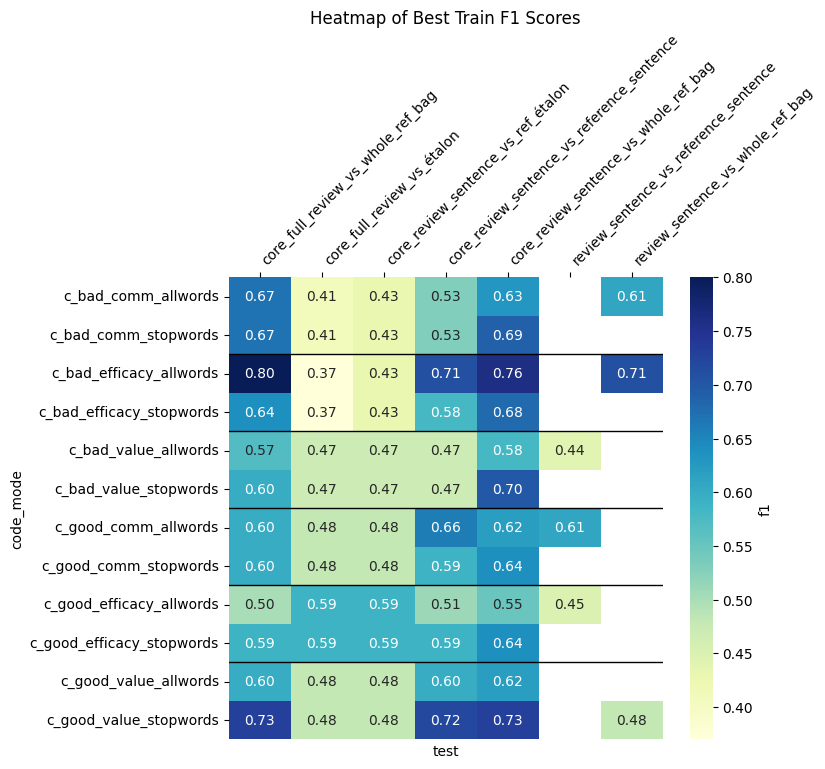

In [213]:
benchmark = compile_benchmarks("validation")
heat()

In [214]:
benchmark = compile_benchmarks("validation")
benchmark

,label,test,word_mode,f1,precision,recall,threshold_used,train_valid_test,code_mode
0,c_bad_efficacy,core_full_review_vs_whole_ref_bag,allwords,0.80,0.80,0.81,0.86,validation,c_bad_efficacy_allwords
0,c_bad_efficacy,core_review_sentence_vs_whole_ref_bag,allwords,0.76,0.76,0.77,0.78,validation,c_bad_efficacy_allwords
0,c_good_value,core_review_sentence_vs_whole_ref_bag,stopwords,0.73,0.97,0.67,0.75,validation,c_good_value_stopwords
0,c_good_value,core_full_review_vs_whole_ref_bag,stopwords,0.73,0.97,0.67,0.72,validation,c_good_value_stopwords
0,c_good_value,core_review_sentence_vs_reference_sentence,stopwords,0.72,0.68,0.78,0.69,validation,c_good_value_stopwords
...,...,...,...,...,...,...,...,...,...
0,c_bad_efficacy,core_review_sentence_vs_ref_étalon,allwords,0.43,0.30,0.50,0.60,validation,c_bad_efficacy_allwords
0,c_bad_comm,core_full_review_vs_étalon,stopwords,0.41,0.35,0.50,0.59,validation,c_bad_comm_stopwords
0,c_bad_comm,core_full_review_vs_étalon,allwords,0.41,0.35,0.50,0.59,validation,c_bad_comm_allwords
0,c_bad_efficacy,core_full_review_vs_étalon,allwords,0.37,0.30,0.50,0.59,validation,c_bad_efficacy_allwords


In [225]:
#best_params = pd.DataFrame()
#label_names = set(benchmark["label"])

best_params = compile_best_params(label_names,best_params)

best_params

,label,Accuracy,best_threshold,Method,Word mode
0,c_good_efficacy,0.64,0.76,core_review_sentence_vs_whole_ref_bag,stopwords
1,c_bad_value,0.70,0.59,core_review_sentence_vs_whole_ref_bag,stopwords
2,c_bad_efficacy,0.80,0.86,core_full_review_vs_whole_ref_bag,allwords
3,c_good_value,0.73,0.75,core_review_sentence_vs_whole_ref_bag,stopwords
4,c_good_comm,0.66,0.84,core_review_sentence_vs_reference_sentence,allwords
5,c_bad_comm,0.69,0.67,core_review_sentence_vs_whole_ref_bag,stopwords


The resulting scores are closer to those from the training benchmark, interestingly for several labels the optimal threshold has been loweredn this is expected since the reference documents were created from the training data and our algorithm now faces unseen data, with less obvious simililarities.

We will now proceed to the test phase, by using the thresholds found to be optimal in the validation phase. We added the validation phase as an intermerdiary that would allow to adjust thresholds to unseen data and still have another round, the test, to evaluate these lower fixed thresholds without seeking optimal thresholds, to get a sense of how well our system would fare when labelling the rest of the dataset. 

# TEST

In [229]:
test = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "test", index_col= 0)
test.text_total = [message.replace("€", " euros") for message in test.text_total]
test["text_stop"] = stop_word_text_list(test['text_total'])


In [231]:
# running the labelling on validation sets using the best parameters from the training 

# good efficacy
one_shot_review_sentence_vs_whole_ref_bag(bag_good_efficacy_stop,test.text_stop, test.c_good_efficacy,"c_good_efficacy",0.76,  "test", "stopwords")
# bad value
one_shot_review_sentence_vs_whole_ref_bag(bag_bad_value_stop,test.text_stop, test.c_bad_value,"c_bad_value",0.59,  "test", "stopwords")
# bad efficacy 
one_shot_review_vs_whole_ref_bag(bag_bad_efficacy,test.text_total, test.c_bad_efficacy,"c_bad_efficacy",0.86,  "test", "allwords")
# good value
one_shot_review_sentence_vs_whole_ref_bag(bag_good_value_stop,test.text_stop, test.c_good_value,"c_good_value",0.75, "test", "stopwords")
# good comm
one_shot_review_sentence_vs_reference_sentence(bag_good_comm,test.text_total, test.c_good_comm,"c_good_comm",0.84,  "test", "allwords")
# bad comm 
one_shot_review_sentence_vs_whole_ref_bag(bag_bad_comm_stop,test.text_stop, test.c_bad_comm,"c_bad_comm",0.67,  "test", "stopwords")

passing review_sentence_vs_whole_ref_bag
threshold: 0.76 f1-score: 0.39
passing review_sentence_vs_whole_ref_bag
threshold: 0.59 f1-score: 0.67
passing review_vs_whole_ref_bag
threshold: 0.86 f1-score: 0.71
passing review_sentence_vs_whole_ref_bag
threshold: 0.75 f1-score: 0.58
passing review_sentence_vs_reference_sentence
threshold: 0.84 f1-score: 0.64
passing review_sentence_vs_whole_ref_bag
threshold: 0.67 f1-score: 0.78


In [235]:
benchmark = compile_best_params("test",best_params)
benchmark

,label,Accuracy,best_threshold,Method,Word mode
0,c_good_efficacy,0.64,0.76,core_review_sentence_vs_whole_ref_bag,stopwords
1,c_bad_value,0.70,0.59,core_review_sentence_vs_whole_ref_bag,stopwords
2,c_bad_efficacy,0.80,0.86,core_full_review_vs_whole_ref_bag,allwords
3,c_good_value,0.73,0.75,core_review_sentence_vs_whole_ref_bag,stopwords
4,c_good_comm,0.66,0.84,core_review_sentence_vs_reference_sentence,allwords
5,c_bad_comm,0.69,0.67,core_review_sentence_vs_whole_ref_bag,stopwords


In [269]:
from transformers import pipeline,AutoTokenizer, TFCamembertForSequenceClassification
import pandas as pd
from tqdm import tqdm
import numpy as np

import sentencepiece
# chargement du modèle
tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFCamembertForSequenceClassification.from_pretrained("tblard/tf-allocine")

classifier=  pipeline("text-classification", model = model, tokenizer= tokenizer)
#tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512,'return_tensors':'pt'}




2024-02-23 09:09:11.220573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.
